In [13]:
import sys
import os
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
import csv
import numpy as np
import matplotlib.pyplot as plt

import cv2
# from google.colab.patches import cv2_imshow
def cv2_imshow(img):
    img = np.concatenate((img[:,:,2:3], img[:,:,1:2], img[:,:,0:1]), axis=2)
    plt.imshow(img)
    plt.show()

# !pip3 install rich
from rich.progress import Progress

from utils import get_abs_path
from a_star import find_path

In [15]:
def load_images(path, size):
  data = []
  f = []

  for (dirpath, dirnames, filenames) in os.walk(path):
      f.extend(filenames)
      break

  with Progress() as progress:
    task = progress.add_task('[yellow]Loading images...', total=size)

    for i in range(size):
      img_path = path + f[i]
      img = cv2.imread(img_path)
      data.append(img)
      progress.update(task, advance=1)

  data = np.array(data)
  # print(data.shape)
  data = np.reshape(data, (-1, 120, 120, 3))
  return data

def get_points(image):
  image = np.copy(image)
  points = []
  width = image.shape[0]
  height = image.shape[1]

  for y in range(height):
    for x in range(width):
      value = image[y, x, 1]
      if value == 255:
        x_p = x + 2
        y_p = y + 2
        points.append(x_p)
        points.append(y_p)
        for i in range(y, y+5):
          for j in range(x, x+5):
            image[i, j, 1] = 0

  return points

def get_coordinates(images, size):

  rows = []
  with Progress() as progress:
    task = progress.add_task('[yellow]Loading coordinates...', total=size)

    for i in range(size):
      points = get_points(images[i])
      rows.append(points)
      progress.update(task, advance=1)

  return rows

def load_data(path, size):

  images = load_images(path, size)
  coordinates = get_coordinates(images, size)
  return images, coordinates

In [16]:
project_path = get_abs_path(1)

dataset_path = project_path + '/data/maps/'
results_path = project_path + '/data/planned_maps/'
results_filename = 'paths.json'

samples_count = 2000
dataset, coordinates = load_data(dataset_path, samples_count)

Loading coordinates... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:00:42

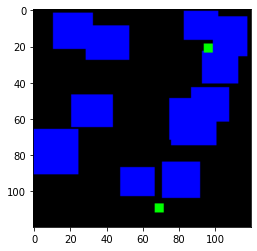

In [17]:
for i in range(1):
  cv2_imshow(dataset[i, :, :, :])

## A* planning algorithm

In [18]:
def mark_path_points(oryg_map, oryg_path):
  map = np.copy(oryg_map)
  path = oryg_path.copy()
  start_point = path[0]
  goal_point = path[-1]
  path = path[1:-1]

  # y, x
  directions_dict = {
    (-1,-1): 'NW',
    (-1, 0): 'N',
    (-1, 1): 'NE',
    ( 0, 1): 'E',
    ( 1, 1): 'SE',
    ( 1, 0): 'S',
    ( 1,-1): 'SW',
    ( 0,-1): 'W'
  }

  mark_points = []
  last_x = start_point[0]
  last_y = start_point[1]
  last_dir = None

  for curr_x, curr_y in path:
    x_change = curr_x - last_x
    y_change = curr_y - last_y
    dir = directions_dict[(y_change, x_change)]

    if dir is not last_dir:
      mark_points.append( (last_x, last_y) )

    last_x = curr_x
    last_y = curr_y
    last_dir = dir

  mark_points.append(goal_point)

  for x, y in mark_points:
    map[y, x, 1] = 0
    map[y, x, 2] = 255
  return map, mark_points

In [19]:
def generate_point_paths(dataset, coordinates):
  size = dataset.shape[0]
  maps = []
  paths = {}

  with Progress() as progress:
    task = progress.add_task('[yellow]Loading images...', total=size)

    for i in range(size):
      map = dataset[i]
      coor = coordinates[i]
      name = 'map_' + str(i)
      map, path = find_path(map, coor)
      map, points = mark_path_points(map, path)
      maps.append(map)
      paths[name] = points
      # cv2_imshow(map)

      progress.update(task, advance=1)

  return maps, paths

Loading images... ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  21% 0:07:57

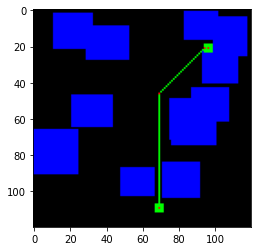

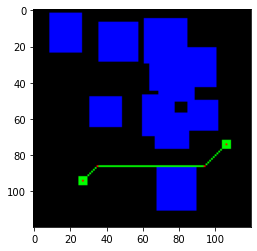

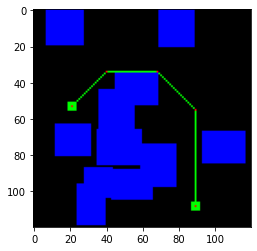

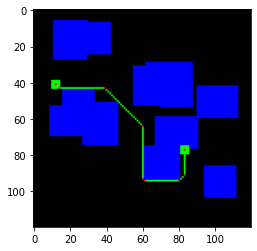

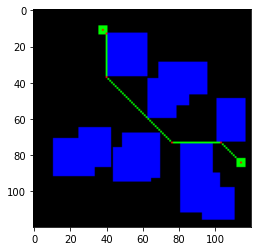

In [20]:
maps, paths = generate_point_paths(dataset, coordinates)

for i in range(5):
  cv2_imshow(maps[i])

In [21]:
import json

with open(results_path + results_filename, 'w') as f:
    json.dump(paths, f)